In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import recom_func as func
import recom_al as al

In [2]:
file_names=['movies_metadata.csv','ratings_small.csv','links_small.csv','keywords.csv']
folder_name='movies_40k'
comp='./movies_40k.zip'

if not(func.checker(file_names,folder_name)):
    if os.path.exists(comp):
        func.unzip(comp,folder_name)
        
    else:                           
        if input('Data not found! Would you like to download the data and continue?\n').lower()=='yes':
            func.data_retrieval(comp)
            func.unzip(comp)
        else:
            exit()

ckecking data...
completed


## Building Model

In [3]:
print('Uploading data...')
warnings.filterwarnings('ignore')
movies=pd.read_csv(f'./{folder_name}/{file_names[0]}')
ratings=pd.read_csv(f'./{folder_name}/{file_names[1]}')
links=pd.read_csv(f'./{folder_name}/{file_names[2]}')
keywords=pd.read_csv(f'./{folder_name}/{file_names[3]}')
print('done!')

Uploading data...
done!


In [4]:
print('Preparing data for modeling...')
ratings=pd.merge(links,ratings,on=['movieId'])

req_columns=['id','title','release_date','production_companies','genres','vote_average','popularity','vote_count','imdb_id']
movies=movies[req_columns]

keywords['words']=keywords['keywords'].apply(func=func.eval_extract,string='name')
keywords.id=keywords.id.astype('str')
movies=pd.merge(movies,keywords,on='id').drop('keywords',axis=1)

movies.genres=movies.genres.apply(func.eval_extract,string='name')
movies.production_companies=movies.production_companies.apply(func=func.eval_extract,string='name')

movies['year']=movies.release_date.str.extract('(\d\d\d\d)')
movies.genres=movies.genres.fillna('not_listed')
movies.production_companies=movies.production_companies.fillna('not_listed')
movies.words=movies.words.fillna('not_listed')

movies=movies.dropna()
movies=movies.groupby('id',sort=False).head(1).reset_index()
movies=movies.drop(['release_date','index'],axis=1)

print('done!')

Preparing data for modeling...
done!


### 1. Demographic recommendations

#### Creating IMDB based rating function

In [5]:
m=movies.vote_count.quantile(0.90)
C=movies.vote_average.mean()

print('Calculating Demographic rating of movies...')
dem_ratings=movies.apply(al.get_rating,C=C,m=m,axis=1)
output_dem=movies[['title','imdb_id','id','year']]
output_dem['ratings']=dem_ratings
output_dem=output_dem.sort_values(by='ratings',ascending=False)
print('Done!')

Calculating Demographic rating of movies...
Done!


#### Showing results

Fetching results...
Showing results...


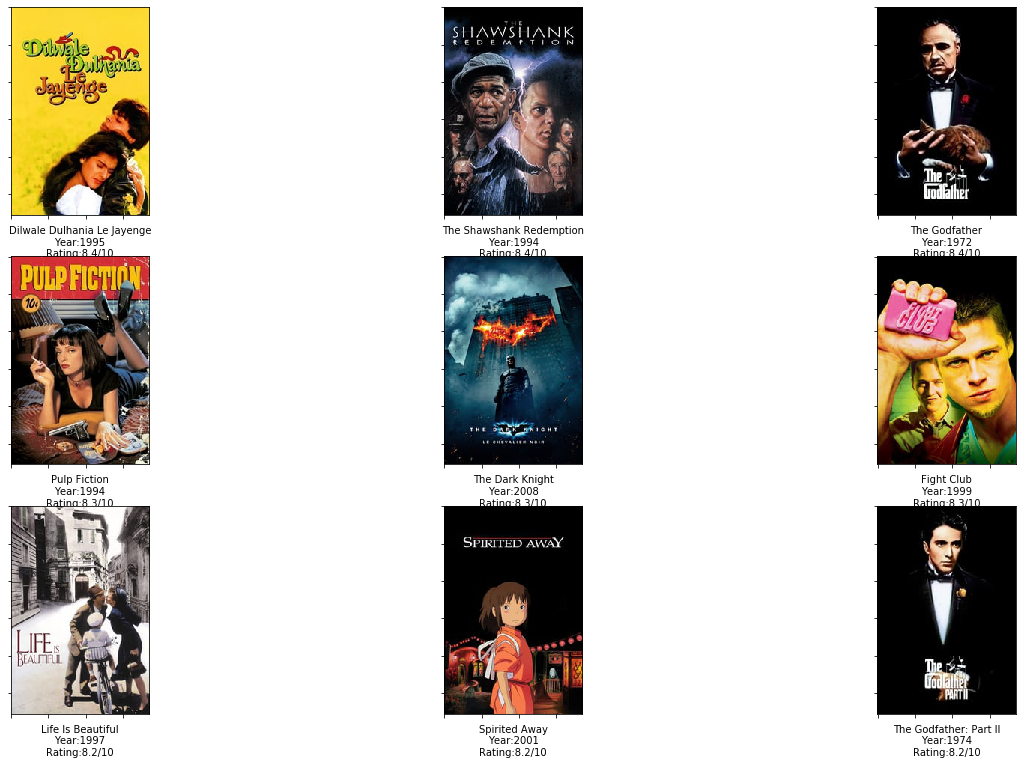

In [6]:
func.show_output(output_dem)

### 2. Hybrid system 

#### Content-based recommendations

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
print('Preparing the Hybrid system...')

vect_gen=TfidfVectorizer()
vect_key=TfidfVectorizer()

vectorised_gen=vect_gen.fit_transform(movies.genres).toarray()
vectorised_key=vect_key.fit_transform(movies.words).toarray()

feature_set=np.append(vectorised_gen,vectorised_key,axis=1)
print('done')

Preparing the Hybrid system...
done


type done to exit the search process and reset to reset inputs.
Enter movie name: inception
searching...
Fetching results...
Showing results...


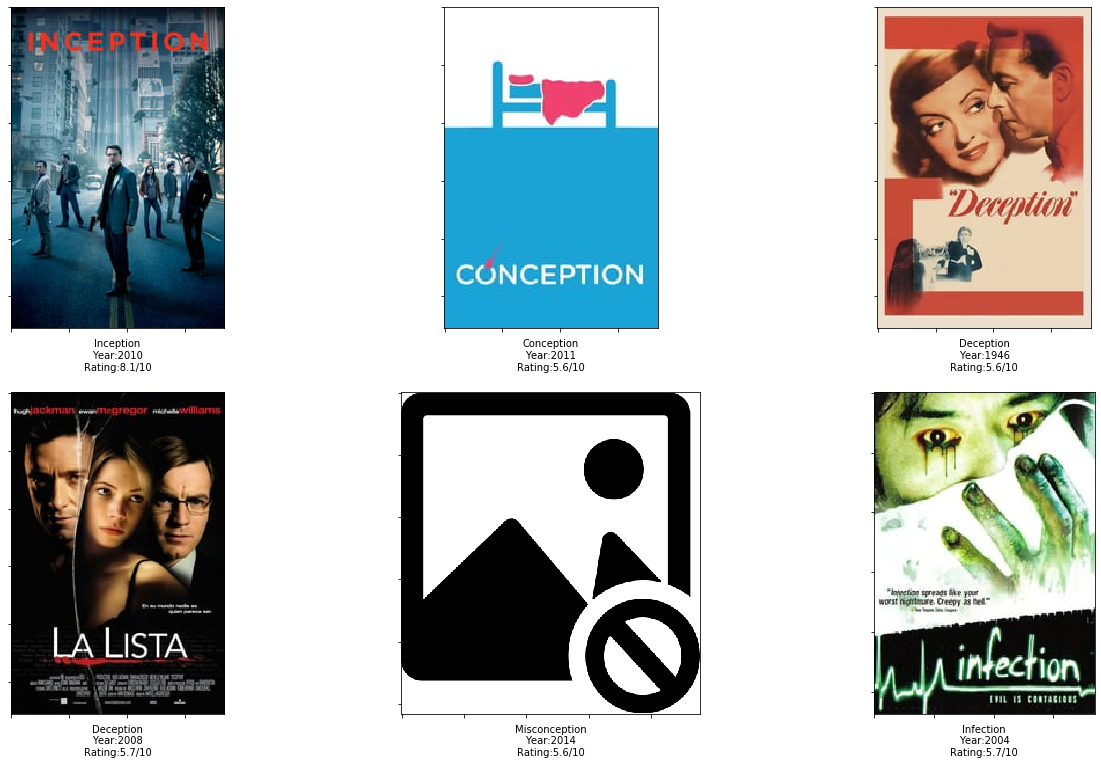

If movie not found type any string(not found!)
Select from the movies. Enter choice number(1-6)1
Rate the movies out of 10: 9
Enter movie name: fight club
searching...
Fetching results...
Showing results...


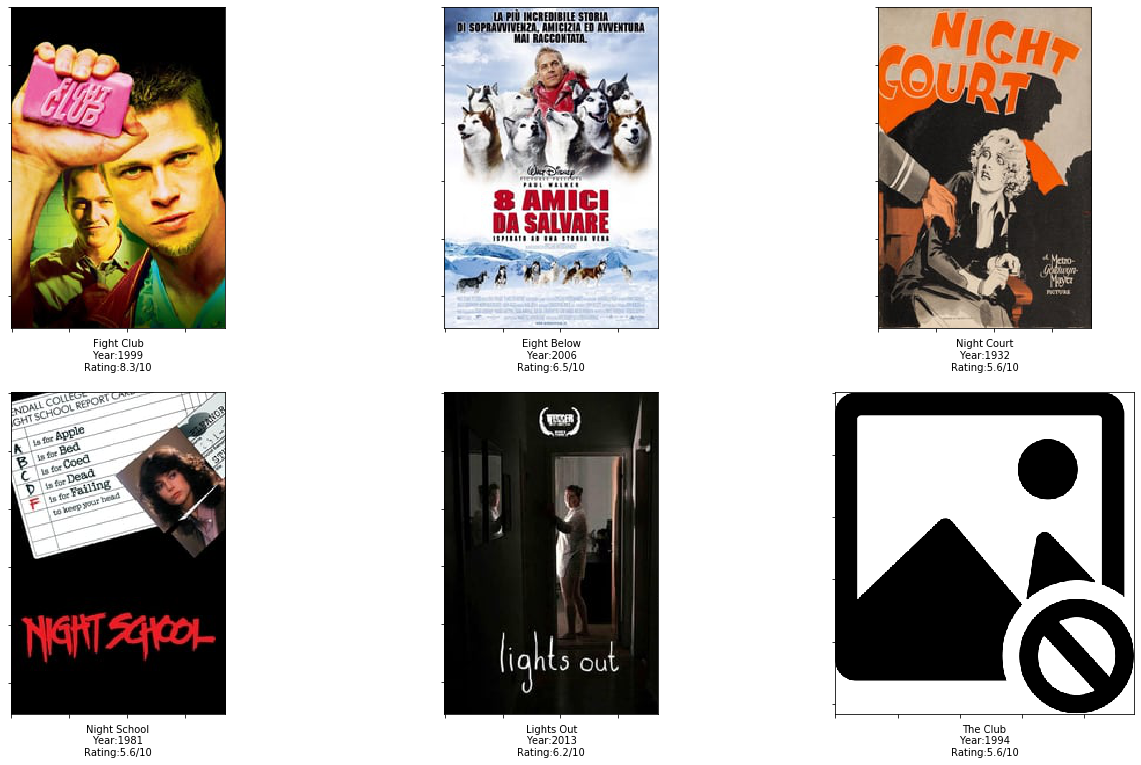

If movie not found type any string(not found!)
Select from the movies. Enter choice number(1-6)1
Rate the movies out of 10: 8
Enter movie name: done


In [19]:
inp_frame=func.search_eng(output_dem)

model_1 implemented successfully.
Fetching results...
Showing results...


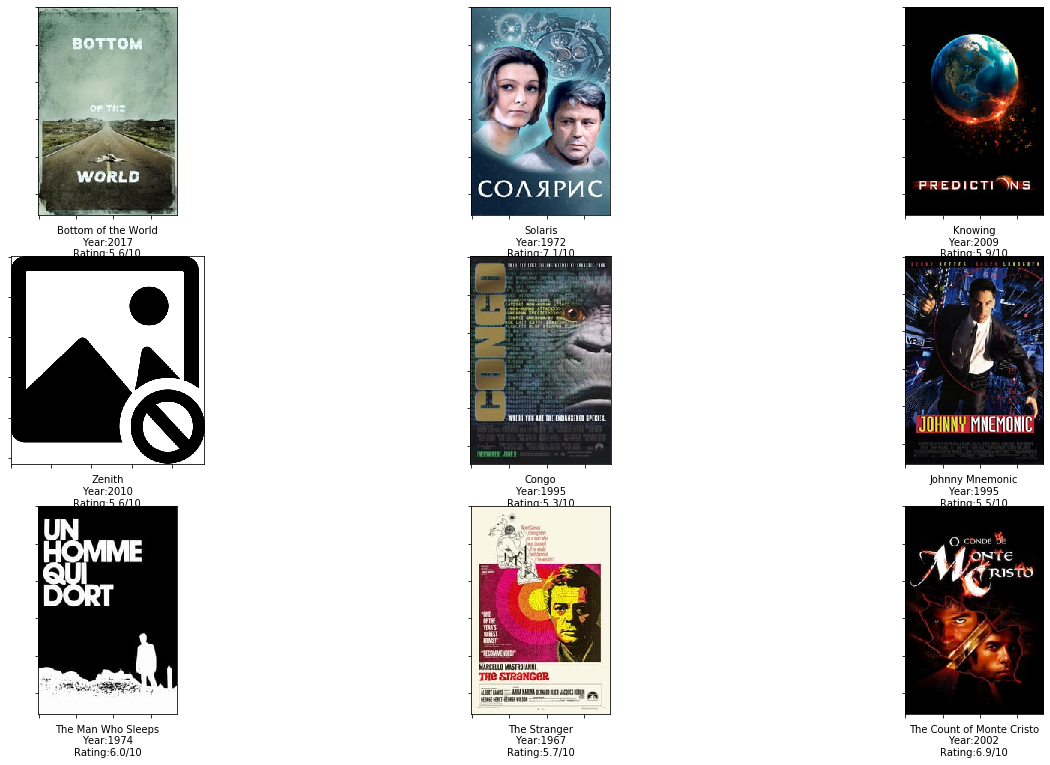

In [20]:
output_cont=al.cont_based(inp_frame,feature_set,output_dem)
func.show_output(output_cont)

#### Item-based collabarative system

In [25]:
movies_user=movies[movies.imdb_id.str.extract('(\d+)').astype('int64')[0].isin(ratings.imdbId)].reset_index()
inp_frame_user=movies_user[movies_user.imdb_id.isin(inp_frame.imdb_id)][['imdb_id','title','year']]
inp_frame_user

,imdb_id,title,year
2367,tt0137523,Fight Club,1999
7512,tt1375666,Inception,2010


In [ ]:
inp_frame_user=movies_user[movies_user.imdb_id.isin(inp_frame.imdb_id)][['id','title','year']]
inp_frame_user

In [ ]:
ind=inp_frame_user.index
inp_frame_user=pd.merge(inp_frame,inp_frame_user,how='inner')

In [ ]:
def extract_users(row):
    var=row['userId'].astype('str').tolist()
    var.append('1')
    return '_user '.join(var)

def extract_ratings(row,vocab):
    r=np.zeros(len(vocab))
    r[row.userId.values-1]=row.rating.values
    return r  

In [ ]:
movie_grp=ratings.groupby('movieId')
users=movie_grp.apply(extract_users)

vocab=np.unique(ratings.userId).astype('str')
vocab='_user '.join(vocab)+'_user'
vocab=vocab.split()

In [ ]:
vect_users=TfidfVectorizer(analyzer='word',vocabulary=vocab,token_pattern=r"(\d+\_\w+)")
feature_set_user=vect_users.fit_transform(users.values).toarray()

rate=movie_grp.apply(extract_ratings,vocab)
final=np.zeros(feature_set_user.shape)
for i in range(len(rate)):
    final[i]=feature_set_user[i]*rate.values[i]

In [ ]:
cont_based(inp_frame_user,final,output_dem[output_dem.imdb_id.isin(movies_user.imdb_id)]).isna().sum()